In [7]:
import transformers
from transformers import ByT5Tokenizer, T5ForConditionalGeneration, T5Config
import torch
import seaborn as sns
from tqdm import tqdm
import numpy as np
import math
import gc
from pynvml import *
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
nvmlInit()


from src.myt5_tokenizer import MyT5Tokenizer

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
mpl.rcParams['font.family'] = 'sans'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'cm'
# bigger size
mpl.rcParams['font.size'] = 14

In [10]:
import matplotlib
matplotlib.get_cachedir()

'/mmfs1/home/tomlim/.cache/matplotlib'

In [11]:
def print_gpu_mem_usage():
    h = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(h)
    print(f'total    : {info.total}')
    print(f'free     : {info.free}')
    print(f'used     : {info.used}')

## Sentence Sample

In [12]:
sentences = ["የአውሮፕላን አብራሪው የአየር ሀይል መሪ ዲሎክሪት ፓታቪ ሆኖ ተለይቷል።",
             "The pilot was identified as Squadron Leader Dilokrit Pattavee.",
             "Der Pilot wurde als Staffelführer Dilokrit Pattavee identifiziert.",
             "Išsiaiškinta, kad pilotas – eskadrilės vadas Dilokritas Pattavee.",
             "涉事飞行员是空军中队长迪罗里·帕塔维 (Dilokrit Pattavee)。",
             "Pilota zidentyfikowano jako Dilokrita Pattavee, dowódcę eskadry."]

sentences_2 =  ['We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.',
                "አሁን የስኳር በሽተኛ ያልነበሩ አሁን ግን የሆኑ የ4-ወር-ዕድሜ ያላቸው አይጦች አሉን፣ አለ። ",
                "„Mamy teraz myszy w wieku 4 miesięcy, które miały cukrzycę, ale zostały z niej wyleczone” – dodał.",
                "「我們有 4 個月大曾經罹患糖尿病老鼠現在沒有糖尿病了」他補充道。"]

prefixes = [sent[:5] for sent in sentences]
sufixes = [sent[5:] for sent in sentences]

## Load Byte and Morpholofical Models

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
byt5_small = T5ForConditionalGeneration.from_pretrained("../hf_checkpoints/byt5_small_250000" ,use_safetensors=True).to(device)
by_tokenizer = ByT5Tokenizer()

In [15]:
myt5_small = T5ForConditionalGeneration.from_pretrained("../hf_checkpoints/myt5_small_250000" ,use_safetensors=True).to(device)
my_tokenizer = MyT5Tokenizer(decompose_map="byte_maps/decompose_map.json",
                               merge_map="byte_maps/merge_map.json")




In [18]:
myt5_base = T5ForConditionalGeneration.from_pretrained("../hf_checkpoints/myt5_base_250000" ,use_safetensors=True).to(device)
myt5_large = T5ForConditionalGeneration.from_pretrained("../hf_checkpoints/myt5_large_250000" ,use_safetensors=True).to(device)

In [22]:
byt5_base = T5ForConditionalGeneration.from_pretrained("../hf_checkpoints/byt5_base_250000" ,use_safetensors=True).to(device)
byt5_large = T5ForConditionalGeneration.from_pretrained("../hf_checkpoints/byt5_large_250000" ,use_safetensors=True).to(device)

In [66]:
byt5_small  = T5ForConditionalGeneration.from_pretrained("google/byt5-small").to(device)
byt5_base  = T5ForConditionalGeneration.from_pretrained("google/byt5-base").to(device)
byt5_large  = T5ForConditionalGeneration.from_pretrained("google/byt5-large").to(device)

In [17]:
# myt5_small_1000000 = T5ForConditionalGeneration.from_pretrained("../hf_checkpoints/myt5_small_1000000" ,use_safetensors=True).to(device)
# byt5_small_1000000  = T5ForConditionalGeneration.from_pretrained("google/byt5-small").to(device)

# TODOs
- check how loss is computed
- run on Flores
- compare multiple models

## Evaluate NLL on sentence levels

In [23]:
def evaluate_texts(text_dataset, model, tokenizer,en_text_dataset=None, batch_size=32, context=0, translation=False):
    
    sentence_nlls = []
    sentence_bpbs = []
    sentence_compressions = []
    context = min(abs(context), 1.0)

    for i in tqdm(range(0, len(text_dataset), batch_size)):
        batch = text_dataset[i:i+batch_size]
        batch_contexts = [math.floor(context * len(sent.split(" "))) for sent in batch]

        if translation and en_text_dataset is not None:
            context = 0
            batch_prefixes = en_text_dataset[i:i+batch_size]
        else:
            batch_prefixes = [" ".join(sent.split(" ")[:bc]) + " " for sent, bc in zip(batch,batch_contexts) ]
        batch_suffixes = ["" + " ".join(sent.split(" ")[bc:]) for sent, bc in zip(batch,batch_contexts) ]
        if en_text_dataset is not None:
            en_byte_lengths = torch.tensor([len(sent.encode("utf-8")) + 1 for sent in en_text_dataset[i:i+batch_size]]).to(device)
        else:
            en_byte_lengths = None
        byte_lengths = torch.tensor([len(suf.encode("utf-8")) +1 for suf in batch_suffixes]).to(device)
        
        if len(batch_prefixes) == 0:
            continue

        inputs = tokenizer(
            batch_prefixes, padding="longest", return_tensors="pt"
        ).to(device)
        targets = tokenizer(
            batch_suffixes, padding="longest", return_tensors="pt"
        ).to(device)

        

        outputs = model(**inputs, labels=targets.input_ids)
        
        logits = outputs.logits
        logits = torch.nn.functional.log_softmax(logits, dim=-1)

        target_labels = targets.input_ids.unsqueeze(-1)
        mask = targets.attention_mask

        target_logits = torch.gather(logits, -1, target_labels).squeeze(-1)

        if en_byte_lengths is not None:
            batch_nlls = -torch.sum(mask * target_logits, axis=-1)/en_byte_lengths
            batch_bpbs = torch.exp(-torch.sum(mask * target_logits , axis=-1)/en_byte_lengths)
        else:
            batch_nlls = -torch.sum(mask * target_logits, axis=-1)/byte_lengths
            batch_bpbs = torch.exp(-torch.sum(mask * target_logits , axis=-1)/byte_lengths)
        batch_compressions = torch.sum(mask, axis=-1) / byte_lengths
        #print(outputs.loss * batch_compressions)
        sentence_nlls.extend(batch_nlls.tolist())
        sentence_bpbs.extend(batch_bpbs.tolist())
        sentence_compressions.extend(batch_compressions.tolist())

        del batch_nlls
        del batch_bpbs
        del byte_lengths
        del batch_compressions
        del targets
        del logits
        del mask
        del target_logits
        del inputs
        
    gc.collect()
    torch.cuda.empty_cache()
    return sentence_nlls, sentence_bpbs, sentence_compressions

In [24]:
sentences = ["የአውሮፕላን አብራሪው የአየር ሀይል መሪ ዲሎክሪት ፓታቪ ሆኖ ተለይቷል።",
             "The pilot was identified as Squadron Leader Dilokrit Pattavee.",
             "Der Pilot wurde als Staffelführer Dilokrit Pattavee identifiziert.",
             "Išsiaiškinta, kad pilotas – eskadrilės vadas Dilokritas Pattavee.",
             "涉事飞行员是空军中队长迪罗里·帕塔维 (Dilokrit Pattavee)。",
             "Pilota zidentyfikowano jako Dilokrita Pattavee, dowódcę eskadry."]

In [25]:
sentences[0]

'የአውሮፕላን አብራሪው የአየር ሀይል መሪ ዲሎክሪት ፓታቪ ሆኖ ተለይቷል።'

In [67]:
evaluate_texts(sentences, myt5_small, my_tokenizer, context=0.0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


([2.8701584339141846,
  2.9268712997436523,
  3.258258104324341,
  3.681589126586914,
  4.1291704177856445,
  3.685049057006836],
 [17.639812469482422,
  18.66912841796875,
  26.004201889038086,
  39.709449768066406,
  62.12636184692383,
  39.847076416015625],
 [0.6499999761581421,
  0.8571428656578064,
  0.8529411554336548,
  0.8873239159584045,
  1.0129870176315308,
  0.8507462739944458])

In [69]:
evaluate_texts(sentences, byt5_small, by_tokenizer, context=0.0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.24it/s]


([3.4779105186462402,
  2.9413836002349854,
  3.104813814163208,
  3.7753567695617676,
  3.6316075325012207,
  3.778974771499634],
 [32.3919677734375,
  18.942035675048828,
  22.305065155029297,
  43.61306381225586,
  37.77349090576172,
  43.77114486694336],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [71]:
evaluate_texts(sentences, myt5_base, my_tokenizer, context=0.0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


([3.4333770275115967,
  3.811155319213867,
  4.128856658935547,
  4.370350360870361,
  5.714946269989014,
  4.2407379150390625],
 [30.981090545654297,
  45.20262908935547,
  62.10687255859375,
  79.07133483886719,
  303.3678894042969,
  69.45909118652344],
 [0.6499999761581421,
  0.8571428656578064,
  0.8529411554336548,
  0.8873239159584045,
  1.0129870176315308,
  0.8507462739944458])

In [70]:
evaluate_texts(sentences, byt5_base, by_tokenizer, context=0.0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.65it/s]


([4.748025417327881,
  5.836391925811768,
  5.9866862297058105,
  5.890405178070068,
  6.051374912261963,
  5.940164089202881],
 [115.35627746582031,
  342.5411682128906,
  398.09326171875,
  361.5517578125,
  424.696533203125,
  379.9972839355469],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [72]:
evaluate_texts(sentences, byt5_base, by_tokenizer, context=0.0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


([4.748025417327881,
  5.836391925811768,
  5.9866862297058105,
  5.890405178070068,
  6.051374912261963,
  5.940164089202881],
 [115.35627746582031,
  342.5411682128906,
  398.09326171875,
  361.5517578125,
  424.696533203125,
  379.9972839355469],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [74]:
evaluate_texts(sentences, myt5_large, my_tokenizer, context=0.0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


([2.67629337310791,
  2.437924385070801,
  2.885538101196289,
  3.4886581897735596,
  3.873964786529541,
  3.449765920639038],
 [14.531131744384766,
  11.449252128601074,
  17.913204193115234,
  32.74198532104492,
  48.13284683227539,
  31.493019104003906],
 [0.6499999761581421,
  0.8571428656578064,
  0.8529411554336548,
  0.8873239159584045,
  1.0129870176315308,
  0.8507462739944458])

In [73]:
evaluate_texts(sentences, byt5_large, by_tokenizer, context=0.0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


([3.3680028915405273,
  2.9542341232299805,
  3.9062671661376953,
  4.152293682098389,
  3.1883232593536377,
  4.285555362701416],
 [29.020511627197266,
  19.187021255493164,
  49.71303176879883,
  63.57966232299805,
  24.24773597717285,
  72.64287567138672],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [32]:
evaluate_texts(sentences, byt5_large, by_tokenizer, context=0.0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


([6.797460079193115,
  6.489077568054199,
  7.615218162536621,
  8.686275482177734,
  7.252666473388672,
  8.668632507324219],
 [895.5697631835938,
  657.9161987304688,
  2028.8372802734375,
  5921.087890625,
  1411.8646240234375,
  5817.53857421875],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [17]:
evaluate_texts(sentences, byt5_small_1000000, by_tokenizer, context=0.0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.58it/s]


([3.4779105186462402,
  2.9413836002349854,
  3.104813814163208,
  3.7753567695617676,
  3.6316075325012207,
  3.778974771499634],
 [32.3919677734375,
  18.942035675048828,
  22.305065155029297,
  43.61306381225586,
  37.77349090576172,
  43.77114486694336],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [17]:
evaluate_texts(sentences, byt5_small, by_tokenizer, context=0.75)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.88it/s]


([2.756924867630005,
  3.739626407623291,
  2.507796049118042,
  4.585384368896484,
  4.640851020812988,
  4.198075771331787],
 [15.751331329345703,
  42.0822639465332,
  12.277840614318848,
  98.04086303710938,
  103.63249969482422,
  66.55813598632812],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

## Load Flores Dataset for some language

In [36]:
# load flores dataset for languages: en, es, pt, fr, it, ro, pl, mt, ja, zh, ko, te, ta

# language sample
languages = ['en', 'de', 'fr', 'ru','pl','ja', 'vi', 'ko','hy', 'kk', 'el', 'ta','te','am', 'sn', 'mt', 'sm', 'st']

palette = sns.color_palette("viridis", len(languages))
languages_colors = {lang: col for lang, col in zip(languages, palette)}
nice_colors = [ ]



# use the code from above to get the flores200 languages
# Latin / Corsican / Hawaiian language not in Flores
languages_flores = {'en': 'eng_Latn', 'ceb': 'ceb_Latn', 'de': 'deu_Latn', 'sv': 'swe_Latn', 'fr': 'fra_Latn', 'nl': 'nld_Latn', 'ru': 'rus_Cyrl', 'es': 'spa_Latn',
                    'it': 'ita_Latn', 'pl': 'pol_Latn', 'ja': 'jpn_Jpan', 'zh': 'zho_Hans', 'uk': 'ukr_Cyrl', 'vi': 'vie_Latn', 'ar': 'arb_Arab',
                    'pt': 'por_Latn', 'fa': 'pes_Arab', 'ca': 'cat_Latn', 'sr': 'srp_Cyrl', 'id': 'ind_Latn', 'ko': 'kor_Hang', 'no': 'nob_Latn',
                    'fi': 'fin_Latn', 'tr': 'tur_Latn', 'cs': 'ces_Latn', 'hu': 'hun_Latn', 'ro': 'ron_Latn', 'eu': 'eus_Latn', 'ms': 'zsm_Latn',
                    'eo': 'epo_Latn', 'he': 'heb_Hebr', 'hy': 'hye_Armn', 'da': 'dan_Latn', 'bg': 'bul_Cyrl', 'cy': 'cym_Latn', 'sk': 'slk_Latn',
                    'uz': 'uzn_Latn', 'et': 'est_Latn', 'be': 'bel_Cyrl', 'kk': 'kaz_Cyrl', 'el': 'ell_Grek', 'lt': 'lit_Latn', 'gl': 'glg_Latn',
                    'ur': 'urd_Arab', 'az': 'azj_Latn', 'sl': 'slv_Latn', 'ka': 'kat_Geor', 'hi': 'hin_Deva', 'th': 'tha_Thai', 'ta': 'tam_Taml',
                    'bn': 'ben_Beng', 'mk': 'mkd_Cyrl',  'lv': 'lvs_Latn', 'af': 'afr_Latn', 'tg': 'tgk_Cyrl', 'my': 'mya_Mymr',
                    'mg': 'plt_Latn', 'sq': 'als_Latn', 'mr': 'mar_Deva', 'te': 'tel_Telu', 'ml': 'mal_Mlym', 'ky': 'kir_Cyrl', 'sw': 'swh_Latn',
                    'jv': 'jav_Latn', 'ht': 'hat_Latn', 'lb': 'ltz_Latn', 'su': 'sun_Latn', 'ku': 'kmr_Latn', 'ga': 'gle_Latn', 'is': 'isl_Latn',
                    'fy': 'fao_Latn', 'pa': 'pan_Guru', 'yo': 'yor_Latn', 'ne': 'npi_Deva', 'ha': 'hau_Latn', 'kn': 'kan_Knda', 'gu': 'guj_Gujr',
                    'mn': 'khk_Cyrl', 'ig': 'ibo_Latn', 'si': 'sin_Sinh', 'ps': 'pbt_Arab', 'gd': 'gla_Latn', 'sd': 'snd_Arab', 'yi': 'ydd_Hebr',
                    'am': 'amh_Ethi', 'sn': 'sna_Latn', 'zu': 'zul_Latn', 'km': 'khm_Khmr', 'so': 'som_Latn', 'mi': 'mri_Latn',
                    'mt': 'mlt_Latn', 'lo': 'lao_Laoo', 'xh': 'xho_Latn', 'sm': 'smo_Latn', 'ny': 'nya_Latn', 'st': 'sot_Latn'}

flores = {}

for lang in languages:
    with open(f'flores200_dataset/devtest/{languages_flores[lang]}.devtest', 'r') as f:
        flores[lang] = f.read().splitlines()

## Compute results

In [75]:
models = {"my_small": myt5_small, "by_small": byt5_small, "my_base": myt5_base, "by_base": byt5_base, "my_large": myt5_large, "by_large": byt5_large}
          # "my_small_1000000": myt5_small_1000000, "by_small_1000000": byt5_small_1000000}

In [77]:
bpbs = {"my_small": {}, "by_small": {}, "my_base": {}, "by_base": {}, "my_large": {}, "by_large": {} }#, "my_small_1000000": {}, "by_small_1000000": {}}
nlls = {"my_small": {}, "by_small": {}, "my_base": {}, "by_base": {}, "my_large": {}, "by_large": {} }#, "my_small_1000000": {}, "by_small_1000000": {}}
comps = {"my_small": {}, "by_small": {}, "my_base": {}, "by_base": {}, "my_large": {}, "by_large": {} }#, "my_small_1000000": {}, "by_small_1000000": {}}



In [78]:
"my_small_1000000".startswith("by_small")

False

In [79]:
for lang in languages:
    print(f"Evaluating: {lang}")
    for model in ("my_small", "by_small", "my_base", "by_base", "my_large", "by_large"): #, "by_small_1000000"):
        # nlls_75["my_small"][lang], bpbs_75["my_small"][lang], comps_75["my_small"][lang] = evaluate_texts(flores[lang], myt5_small, my_tokenizer, flores['en'], batch_size=8, context=0.75)
        # nlls_75["my_small"][lang], bpbs_75["by_small"][lang], nlls_75["by_small"][lang], comps_75["by_small"][lang] = evaluate_texts(flores[lang], byt5_small, by_tokenizer, batch_size=4, context=0.75)

        #nlls["my_small"][lang],bpbs["my_small"][lang], comps["my_small"][lang] = evaluate_texts(flores[lang], myt5_small, my_tokenizer,flores['en'], batch_size=8, context=0.0)
        if model.startswith("by"):
            nlls[model][lang],bpbs[model][lang], comps[model][lang] = evaluate_texts(flores[lang], models[model], by_tokenizer,flores['en'], batch_size=2, context=0.0)
        else:
            nlls[model][lang],bpbs[model][lang], comps[model][lang] = evaluate_texts(flores[lang], models[model], my_tokenizer,flores['en'], batch_size=4, context=0.0)
        print_gpu_mem_usage()

Evaluating: en


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:05<00:00, 46.29it/s]


total    : 48305799168
free     : 25918046208
used     : 22387752960


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 54.99it/s]


total    : 48305799168
free     : 26412974080
used     : 21892825088


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:08<00:00, 29.99it/s]


total    : 48305799168
free     : 25670582272
used     : 22635216896


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:13<00:00, 37.94it/s]


total    : 48305799168
free     : 26178093056
used     : 22127706112


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:16<00:00, 15.27it/s]


total    : 48305799168
free     : 24672337920
used     : 23633461248


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:26<00:00, 19.09it/s]


total    : 48305799168
free     : 25735593984
used     : 22570205184
Evaluating: de


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:05<00:00, 42.86it/s]


total    : 48305799168
free     : 25645416448
used     : 22660382720


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 54.59it/s]


total    : 48305799168
free     : 26234716160
used     : 22071083008


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 27.23it/s]


total    : 48305799168
free     : 25150488576
used     : 23155310592


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:13<00:00, 36.62it/s]


total    : 48305799168
free     : 25913851904
used     : 22391947264


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:20<00:00, 12.40it/s]


total    : 48305799168
free     : 23367909376
used     : 24937889792


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:31<00:00, 16.00it/s]


total    : 48305799168
free     : 25068699648
used     : 23237099520
Evaluating: fr


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:05<00:00, 42.18it/s]


total    : 48305799168
free     : 25909657600
used     : 22396141568


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 54.25it/s]


total    : 48305799168
free     : 26299727872
used     : 22006071296


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:10<00:00, 24.60it/s]


total    : 48305799168
free     : 25492324352
used     : 22813474816


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:14<00:00, 36.04it/s]


total    : 48305799168
free     : 26025000960
used     : 22280798208


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:18<00:00, 13.55it/s]


total    : 48305799168
free     : 23258857472
used     : 25046941696


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:27<00:00, 18.35it/s]


total    : 48305799168
free     : 25163071488
used     : 23142727680
Evaluating: ru


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 41.05it/s]


total    : 48305799168
free     : 26081624064
used     : 22224175104


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:10<00:00, 47.22it/s]


total    : 48305799168
free     : 25947406336
used     : 22358392832


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 26.06it/s]


total    : 48305799168
free     : 25335037952
used     : 22970761216


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:16<00:00, 30.02it/s]


total    : 48305799168
free     : 25498615808
used     : 22807183360


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:19<00:00, 13.10it/s]


total    : 48305799168
free     : 23588110336
used     : 24717688832


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:34<00:00, 14.77it/s]


total    : 48305799168
free     : 24460525568
used     : 23845273600
Evaluating: pl


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:05<00:00, 43.22it/s]


total    : 48305799168
free     : 25823674368
used     : 22482124800


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 54.34it/s]


total    : 48305799168
free     : 26341670912
used     : 21964128256


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 27.63it/s]


total    : 48305799168
free     : 25225986048
used     : 23079813120


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:13<00:00, 37.02it/s]


total    : 48305799168
free     : 26100498432
used     : 22205300736


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:18<00:00, 14.03it/s]


total    : 48305799168
free     : 23923654656
used     : 24382144512


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:27<00:00, 18.70it/s]


total    : 48305799168
free     : 25813188608
used     : 22492610560
Evaluating: ja


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 41.01it/s]


total    : 48305799168
free     : 25892880384
used     : 22412918784


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 54.31it/s]


total    : 48305799168
free     : 26310213632
used     : 21995585536


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 25.65it/s]


total    : 48305799168
free     : 25049825280
used     : 23255973888


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:17<00:00, 28.58it/s]


total    : 48305799168
free     : 26115178496
used     : 22190620672


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:19<00:00, 12.90it/s]


total    : 48305799168
free     : 22937993216
used     : 25367805952


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:27<00:00, 18.28it/s]


total    : 48305799168
free     : 25511198720
used     : 22794600448
Evaluating: vi


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 37.70it/s]


total    : 48305799168
free     : 25653805056
used     : 22651994112


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 52.44it/s]


total    : 48305799168
free     : 26178093056
used     : 22127706112


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:10<00:00, 23.24it/s]


total    : 48305799168
free     : 24777195520
used     : 23528603648


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:14<00:00, 34.81it/s]


total    : 48305799168
free     : 25962086400
used     : 22343712768


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:21<00:00, 11.58it/s]


total    : 48305799168
free     : 22447259648
used     : 25858539520


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:28<00:00, 17.51it/s]


total    : 48305799168
free     : 24917704704
used     : 23388094464
Evaluating: ko


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:05<00:00, 43.36it/s]


total    : 48305799168
free     : 25876103168
used     : 22429696000


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 55.34it/s]


total    : 48305799168
free     : 26410876928
used     : 21894922240


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 27.31it/s]


total    : 48305799168
free     : 25450381312
used     : 22855417856


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:13<00:00, 36.68it/s]


total    : 48305799168
free     : 26155024384
used     : 22150774784


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:18<00:00, 13.73it/s]


total    : 48305799168
free     : 23908974592
used     : 24396824576


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:27<00:00, 18.59it/s]


total    : 48305799168
free     : 25813188608
used     : 22492610560
Evaluating: hy


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 41.07it/s]


total    : 48305799168
free     : 25817382912
used     : 22488416256


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:11<00:00, 45.00it/s]


total    : 48305799168
free     : 25804800000
used     : 22500999168


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 26.11it/s]


total    : 48305799168
free     : 25033048064
used     : 23272751104


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:17<00:00, 29.43it/s]


total    : 48305799168
free     : 25018368000
used     : 23287431168


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:19<00:00, 13.23it/s]


total    : 48305799168
free     : 23707648000
used     : 24598151168


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:34<00:00, 14.47it/s]


total    : 48305799168
free     : 23737008128
used     : 24568791040
Evaluating: kk


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:05<00:00, 42.24it/s]


total    : 48305799168
free     : 25750274048
used     : 22555525120


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:10<00:00, 47.79it/s]


total    : 48305799168
free     : 25834160128
used     : 22471639040


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 26.97it/s]


total    : 48305799168
free     : 25192431616
used     : 23113367552


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:16<00:00, 30.70it/s]


total    : 48305799168
free     : 25335037952
used     : 22970761216


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:18<00:00, 13.73it/s]


total    : 48305799168
free     : 23581818880
used     : 24723980288


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:33<00:00, 15.13it/s]


total    : 48305799168
free     : 23716036608
used     : 24589762560
Evaluating: el


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 36.51it/s]


total    : 48305799168
free     : 25790119936
used     : 22515679232


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:11<00:00, 45.44it/s]


total    : 48305799168
free     : 25884491776
used     : 22421307392


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:11<00:00, 22.38it/s]


total    : 48305799168
free     : 24542314496
used     : 23763484672


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:17<00:00, 28.48it/s]


total    : 48305799168
free     : 25299386368
used     : 23006412800


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:22<00:00, 11.23it/s]


total    : 48305799168
free     : 23304994816
used     : 25000804352


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:36<00:00, 13.97it/s]


total    : 48305799168
free     : 23437115392
used     : 24868683776
Evaluating: ta


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 38.52it/s]


total    : 48305799168
free     : 25764954112
used     : 22540845056


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:13<00:00, 37.76it/s]


total    : 48305799168
free     : 25137905664
used     : 23167893504


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:10<00:00, 24.45it/s]


total    : 48305799168
free     : 24907218944
used     : 23398580224


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:22<00:00, 22.41it/s]


total    : 48305799168
free     : 24030609408
used     : 24275189760


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:20<00:00, 12.51it/s]


total    : 48305799168
free     : 22948478976
used     : 25357320192


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:46<00:00, 10.82it/s]


total    : 48305799168
free     : 21469986816
used     : 26835812352
Evaluating: te


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 40.20it/s]


total    : 48305799168
free     : 25863520256
used     : 22442278912


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:12<00:00, 41.30it/s]


total    : 48305799168
free     : 25685262336
used     : 22620536832


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 25.85it/s]


total    : 48305799168
free     : 25341329408
used     : 22964469760


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:20<00:00, 25.27it/s]


total    : 48305799168
free     : 25188237312
used     : 23117561856


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:19<00:00, 13.25it/s]


total    : 48305799168
free     : 23583916032
used     : 24721883136


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:41<00:00, 12.30it/s]


total    : 48305799168
free     : 24164827136
used     : 24140972032
Evaluating: am


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 41.82it/s]


total    : 48305799168
free     : 25949503488
used     : 22356295680


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:10<00:00, 49.67it/s]


total    : 48305799168
free     : 26006126592
used     : 22299672576


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 26.41it/s]


total    : 48305799168
free     : 25267929088
used     : 23037870080


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:15<00:00, 32.42it/s]


total    : 48305799168
free     : 25511198720
used     : 22794600448


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:18<00:00, 13.51it/s]


total    : 48305799168
free     : 23671996416
used     : 24633802752


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:31<00:00, 16.10it/s]


total    : 48305799168
free     : 24613617664
used     : 23692181504
Evaluating: sn


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:05<00:00, 44.83it/s]


total    : 48305799168
free     : 26222133248
used     : 22083665920


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 56.07it/s]


total    : 48305799168
free     : 26371031040
used     : 21934768128


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:08<00:00, 28.53it/s]


total    : 48305799168
free     : 25678970880
used     : 22626828288


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:13<00:00, 37.53it/s]


total    : 48305799168
free     : 26230521856
used     : 22075277312


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:17<00:00, 14.33it/s]


total    : 48305799168
free     : 24431165440
used     : 23874633728


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:26<00:00, 18.96it/s]


total    : 48305799168
free     : 25775439872
used     : 22530359296
Evaluating: mt


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:05<00:00, 44.14it/s]


total    : 48305799168
free     : 25704136704
used     : 22601662464


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 55.66it/s]


total    : 48305799168
free     : 26264076288
used     : 22041722880


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 27.98it/s]


total    : 48305799168
free     : 25202917376
used     : 23102881792


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:13<00:00, 37.13it/s]


total    : 48305799168
free     : 25867714560
used     : 22438084608


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:17<00:00, 14.12it/s]


total    : 48305799168
free     : 23531487232
used     : 24774311936


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:26<00:00, 18.75it/s]


total    : 48305799168
free     : 25381175296
used     : 22924623872
Evaluating: sm


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 41.85it/s]


total    : 48305799168
free     : 25783828480
used     : 22521970688


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 55.23it/s]


total    : 48305799168
free     : 26312310784
used     : 21993488384


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 25.95it/s]


total    : 48305799168
free     : 24932384768
used     : 23373414400


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:13<00:00, 36.71it/s]


total    : 48305799168
free     : 26037583872
used     : 22268215296


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:19<00:00, 13.14it/s]


total    : 48305799168
free     : 22954770432
used     : 25351028736


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:27<00:00, 18.48it/s]


total    : 48305799168
free     : 25400049664
used     : 22905749504
Evaluating: st


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 42.02it/s]


total    : 48305799168
free     : 25678970880
used     : 22626828288


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:09<00:00, 54.99it/s]


total    : 48305799168
free     : 26329088000
used     : 21976711168


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 26.32it/s]


total    : 48305799168
free     : 24873664512
used     : 23432134656


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:13<00:00, 36.67it/s]


total    : 48305799168
free     : 25867714560
used     : 22438084608


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:19<00:00, 13.28it/s]


total    : 48305799168
free     : 23523098624
used     : 24782700544


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 506/506 [00:27<00:00, 18.56it/s]


total    : 48305799168
free     : 25223888896
used     : 23081910272


In [80]:
print_gpu_mem_usage()

total    : 48305799168
free     : 25223888896
used     : 23081910272


In [81]:
from copy import copy

## Analysis of the results

In [82]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [83]:
def plot_paired_boxplot(nested_dict, y_label="NLL", title=None, y_logscale=True, models=("by_small", "my_small")):

    plt.figure(figsize=(12, 6))
    # plt.style.use(['science', 'ieee', 'no-latex'])
    # matplotlib.rc('font', family='times new roman')
    model_name_dict = {"by_small": "byT5 small", "my_small": "myT5 small", 
                       "my_base": "myT5 base", "by_base": "byT5 base",
                       "my_large": "myT5 large", "by_large": "byT5 large",
                      "my_small_1000000": "myT5 fully t", "by_small_1000000": "byT5 fully t"}
    data = []
    for model, model_vals in nested_dict.items():
        if model not in models:
            continue
        for lang, lang_vals in model_vals.items():
            for val in lang_vals:
                data.append([lang, model_name_dict[model], val])
    df = pd.DataFrame(data, columns=['Language', 'Model', y_label])
    flierprops = dict(marker='o', markersize=5, markerfacecolor='grey', alpha=0.1)
    sns.boxplot(x='Language', y=y_label, hue='Model', data=df,flierprops= flierprops)

    if y_logscale:
        plt.yscale('log')
    else:
        plt.ylim(0,60)

    if title:
        plt.savefig(f"{title}.png", dpi=300)
    plt.show()

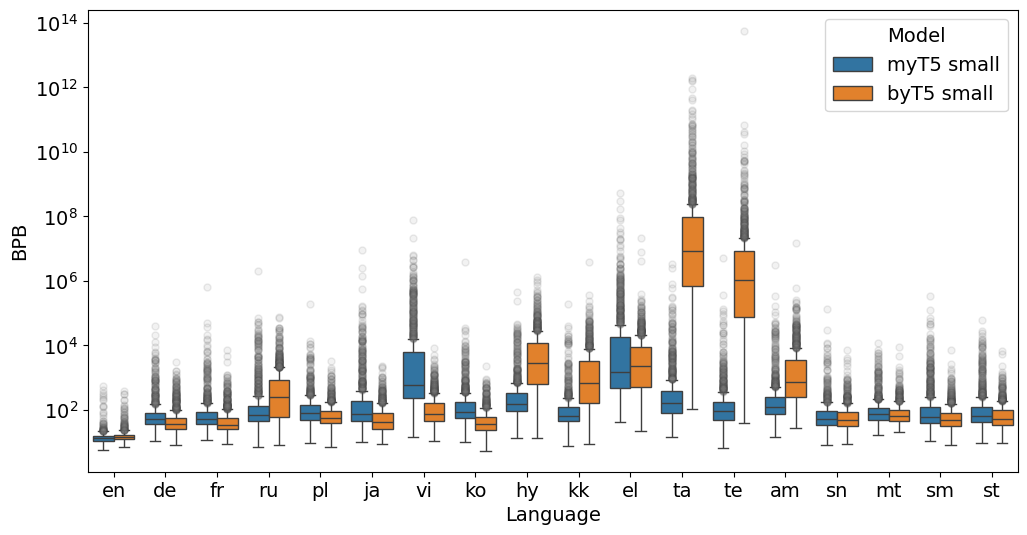

In [84]:
plot_paired_boxplot(bpbs, y_label="BPB", title="bpeb_no_context_en_normed")

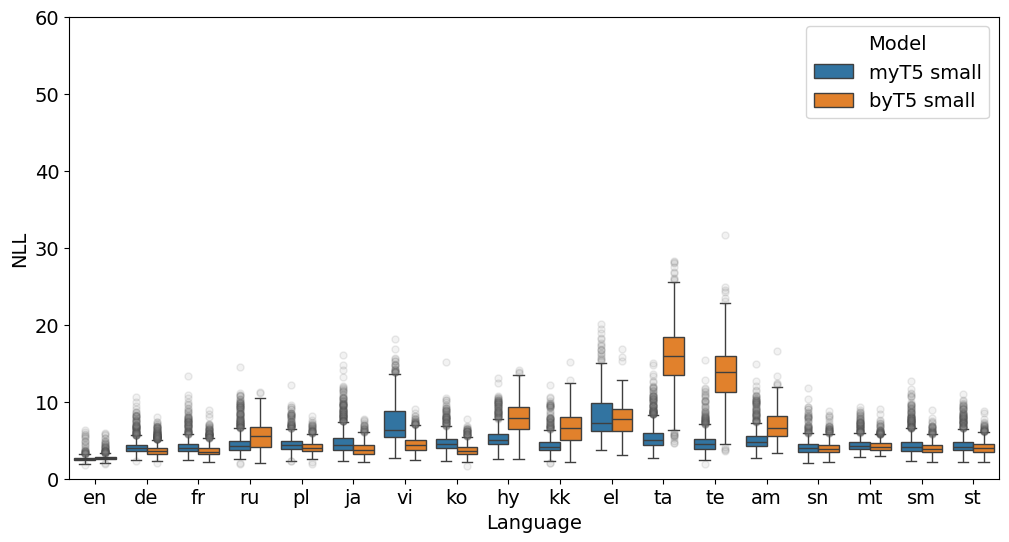

In [85]:
plot_paired_boxplot(nlls, title="nlls_no_context_en_normed",  y_logscale=False)

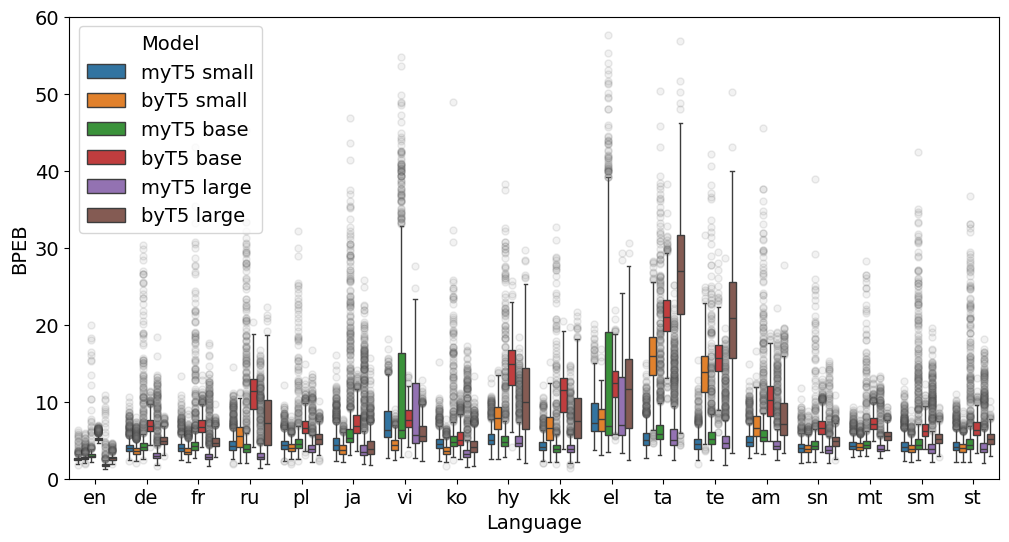

In [86]:
plot_paired_boxplot(nlls, y_label="BPEB", title="bpeb_no_context_en_normed_training_steps", models=("my_small", "by_small",
                                                                                                   "my_base", "by_base",
                                                                                                   "my_large", "by_large"),  y_logscale=False)

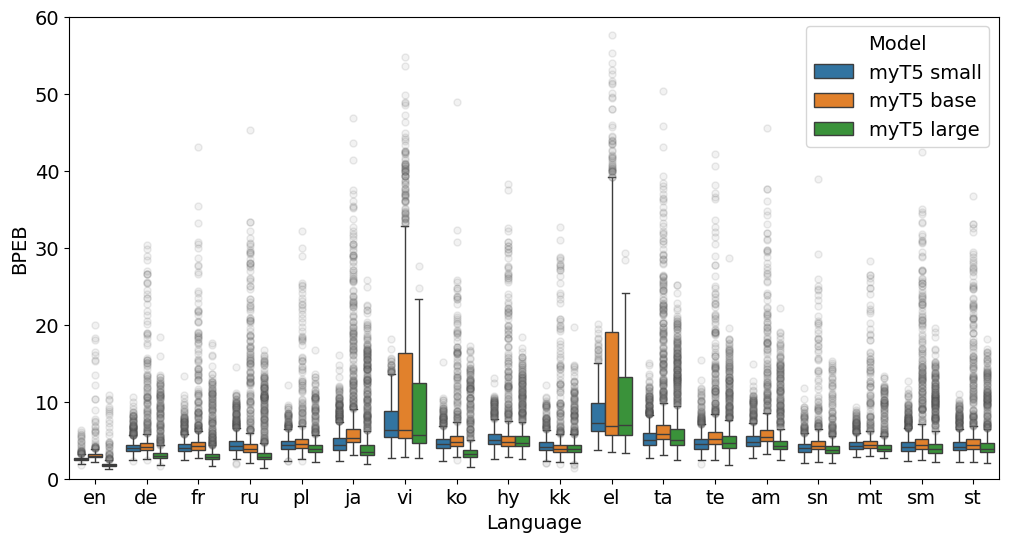

In [87]:
plot_paired_boxplot(nlls, y_label="BPEB", title="bpeb_no_context_en_normed_training_steps", models=("my_small",
                                                                                                   "my_base", 
                                                                                                   "my_large",),y_logscale=False)

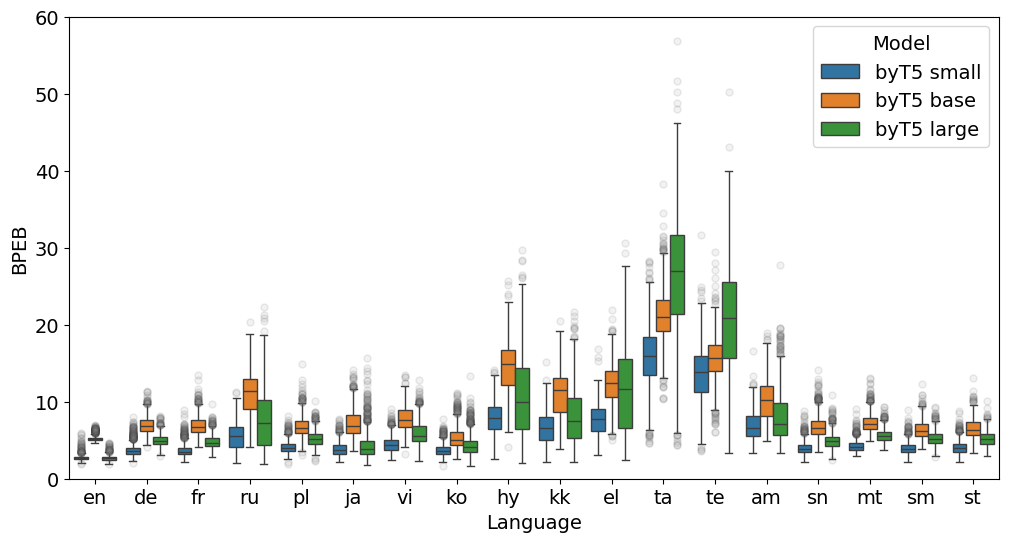

In [90]:
plot_paired_boxplot(nlls, y_label="BPEB", title="bpeb_no_context_en_normed_training_steps", models=("by_small",
                                                                                                   "by_base", 
                                                                                                   "by_large",), y_logscale=False)

# Datasets

In [91]:
def create_dfs(res_dict, value_column='NLL'):
    data_list = []
    for model, model_vals in res_dict.items():
        for lang, lang_vals in model_vals.items():
            for val in lang_vals:
                data_list.append([lang, model, val])
    data_df = pd.DataFrame(data_list, columns=['Language', 'Model', value_column])
    avg_df = data_df.groupby(['Language', 'Model'])[value_column].mean().reset_index()

    return data_df, avg_df


In [92]:
nlls_data, nlls_avg = create_dfs(nlls, "NLL")
comp_data, comp_avg = create_dfs(comps, "Compressions")

In [93]:
nlls_data

,Language,Model,NLL
0,en,my_small,3.098666
1,en,my_small,2.469221
2,en,my_small,2.579489
3,en,my_small,4.842084
4,en,my_small,2.564179
...,...,...,...
109291,st,by_large,4.396771
109292,st,by_large,6.602256
109293,st,by_large,6.026866
109294,st,by_large,6.409793


In [94]:
nlls_avg.head(60)

,Language,Model,NLL
0,am,by_base,10.260616
1,am,by_large,8.106943
2,am,by_small,6.940521
3,am,my_base,6.922951
4,am,my_large,5.178775
5,am,my_small,5.134385
6,de,by_base,6.976376
7,de,by_large,4.995532
8,de,by_small,3.777000
9,de,my_base,5.067692


In [95]:
comp_avg

,Language,Model,Compressions
0,am,by_base,1.000000
1,am,by_large,1.000000
2,am,by_small,1.000000
3,am,my_base,0.622460
4,am,my_large,0.622460
...,...,...,...
103,vi,by_large,1.000000
104,vi,by_small,1.000000
105,vi,my_base,0.991384
106,vi,my_large,0.991384


In [101]:
# bpb_my = data_my_t5.perplexity_bytes
# bpb_by = data_by_t5.perplexity_bytes

# bpb_enc_my = data_my_t5.perplexity_encoded
# bpb_enc_by = data_by_t5.perplexity_encoded

nll_delta = nlls_avg[nlls_avg.Model == "my_large"]["NLL"].values - nlls_avg[nlls_avg.Model == "by_large"]["NLL"].values
compression = 1. - comp_avg[comp_avg.Model == "my_large"]["Compressions"].values
languages = comp_avg[comp_avg.Model == "my_large"]["Language"].values

# Plot differences

In [102]:
# LANGUAGES_ALL = ['af', 'am', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'ceb', 'co', 'cs', 'cy', 'da', 'de', 'el', 'en', 'eo', 'es', 
#                  'et', 'eu', 'fa', 'fi', 'fil', 'fr', 'fy', 'ga', 'gd', 'gl', 'gu', 'ha', 'haw','hi', 'hmn', 'ht', 'hu', 'hy',
#                  'id', 'ig', 'is', 'it', 'iw', 'ja', 'jv', 'ka', 'kk', 'km', 'kn', 'ko', 'ku', 'ky', 'la', 'lb', 'lo', 'lt', 'lv',
#                  'mg', 'mi', 'mk', 'ml', 'mn', 'mr', 'ms', 'mt', 'my', 'ne', 'nl', 'no', 'ny', 'pa', 'pl', 'ps', 'pt', 'ro', 'ru',
#                  'sd', 'si', 'sk', 'sl', 'sm', 'sn', 'so', 'sq', 'sr', 'st', 'su', 'sv', 'sw', 'ta', 'te', 'tg', 'th', 'uk', 'ur',
#                  'uz', 'vi', 'xh', 'yi', 'yo', 'zh', 'zu']

LANGUAGES_ALL = languages


LANGUAGE_TO_SCRIPT = {'af': 'Latn', 'am': 'Ethi', 'ar': 'Arab', 'az': 'Latn', 'be': 'Cyrl', 'bg': 'Cyrl', 'bn': 'Beng', 'ca': 'Latn',
                      'ceb': 'Latn', 'co': 'Latn', 'cs': 'Latn', 'cy': 'Latn', 'da': 'Latn', 'de': 'Latn', 'el': 'Grek', 'en': 'Latn', 
                      'eo': 'Latn', 'es': 'Latn', 'et': 'Latn', 'eu': 'Latn', 'fa': 'Arab', 'fi': 'Latn', 'fil': 'Latn', 'fr': 'Latn', 
                      'fy': 'Latn', 'ga': 'Latn', 'gd': 'Latn', 'gl': 'Latn', 'gu': 'Gujr', 'ha': 'Latn', 'haw': 'Latn','hi': 'Deva',
                      'hmn': 'Latn', 'ht': 'Latn', 'hu': 'Latn', 'hy': 'Armn', 'id': 'Latn', 'ig': 'Latn', 'is': 'Latn', 'it': 'Latn', 
                      'iw': 'Hebr', 'ja': 'Japn', 'jv': 'Latn', 'ka': 'Geor', 'kk': 'Cyrl', 'km': 'Khmr', 'kn': 'Knda', 'ko': 'Kore', 
                      'ku': 'Latn', 'ky': 'Cyrl', 'la': 'Latn', 'lb': 'Latn', 'lo': 'Lao', 'lt': 'Latn', 'lv': 'Latn', 'mg': 'Latn',
                      'mi': 'Latn', 'mk': 'Cyrl', 'ml': 'Mlym', 'mn': 'Cyrl', 'mr': 'Deva', 'ms': 'Latn', 'mt': 'Latn', 'my': 'Mymr', 
                      'ne': 'Deva', 'nl': 'Latn', 'no': 'Latn', 'ny': 'Latn', 'pa': 'Guru', 'pl': 'Latn', 'ps': 'Arab', 'pt': 'Latn',
                      'ro': 'Latn', 'ru': 'Cyrl', 'sd': 'Arab', 'si': 'Sinh', 'sk': 'Latn', 'sl': 'Latn', 'sm': 'Latn', 'sn': 'Latn',
                      'so': 'Latn', 'sq': 'Latn', 'sr': 'Cyrl', 'st': 'Latn', 'su': 'Latn', 'sv': 'Latn', 'sw': 'Latn', 'ta': 'Taml', 
                      'te': 'Telu', 'tg': 'Cyrl', 'th': 'Thai', 'uk': 'Cyrl', 'ur': 'Arab', 'uz': 'Latn', 'vi': 'Latn', 'xh': 'Latn',
                      'yi': 'Hebr', 'yo': 'Latn', 'zh': 'Hans', 'zu': 'Latn'}
# more general script categories
SCRIPT_TO_CATEGORY = {'Latn': 'Latn', 'Ethi': 'Ethi', 'Arab': 'Arab', 'Cyrl': 'Cyrl', 'Beng': 'Indic', 'Grek': 'Other Alpha', 'Deva': 'Indic',
                      'Gujr': 'Indic', 'Hebr': 'Hebr', 'Japn': 'CJK', 'Geor': 'Other Alpha', 'Khmr': 'Indic', 'Knda': 'Indic', 'Lao': 'Indic',
                      'Mlym': 'Indic', 'Mymr': 'Indic', 'Sinh': 'Indic', 'Taml': 'Indic', 'Telu': 'Indic', 'Thai': 'Thai', 'Hans': 'CJK',
                      'Hant': 'CJK', 'Kore': 'CJK', 'Armn': 'Other Alpha', 'Guru': 'Indic'}
LANGUAGE_TO_SCRIPT_CATEGORY = {lang: SCRIPT_TO_CATEGORY[script] for lang, script in LANGUAGE_TO_SCRIPT.items()}

palette = sns.color_palette("tab10", len(set(LANGUAGE_TO_SCRIPT_CATEGORY.values())))
category_colors = {cat: col for cat, col in zip(set(LANGUAGE_TO_SCRIPT_CATEGORY.values()), palette)}
languages_colors = [category_colors[LANGUAGE_TO_SCRIPT_CATEGORY[lang]] for lang in LANGUAGES_ALL]

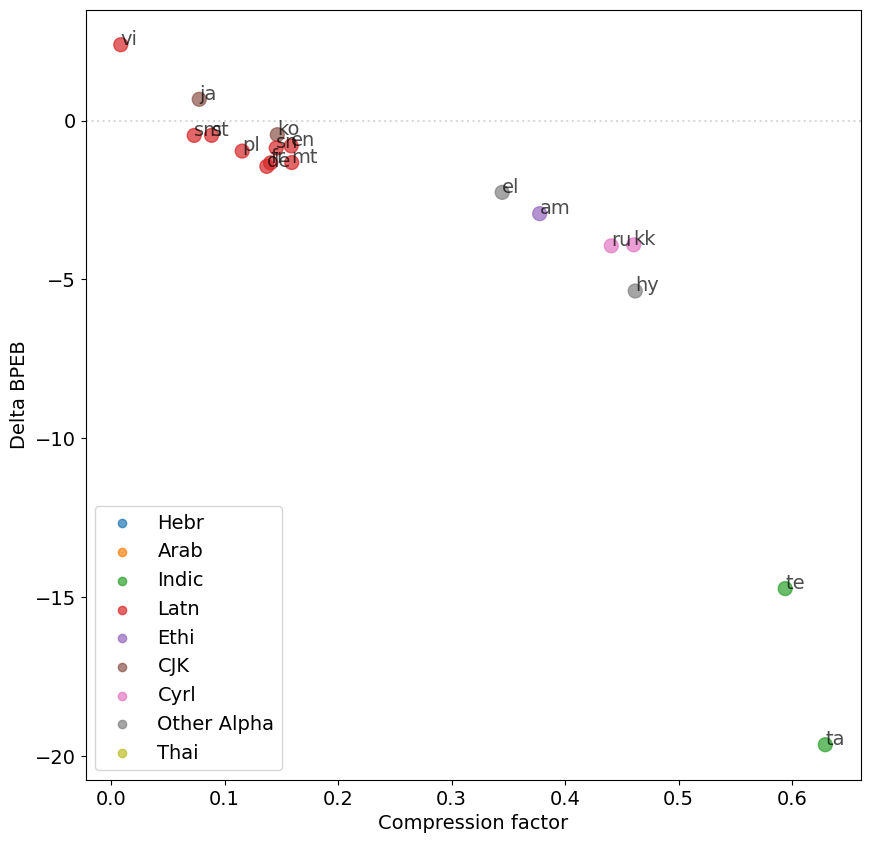

In [137]:
fig, ax = plt.subplots(figsize=(10, 10))

# plot with colors by script
scatter = plt.scatter(compression, nll_delta, c=languages_colors, s=100, alpha=0.7)
ax.set_xlabel('Compression factor')
ax.set_ylabel(r'Delta BPEB')

for script, color in category_colors.items():
    plt.scatter([], [], color=color, label=script, alpha=0.7)
plt.legend()


plt.axhline(y=0, color='grey', linestyle=':', alpha=0.3)


for i, language in enumerate(languages):
    ax.annotate(language, (compression[i], nll_delta[i]), alpha=0.7)

# fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()
fig.savefig('bpeb_delta.png')

## NLL results by size

nlls_avg

In [116]:
nlls_avg['Model'].str[3:]

0       base
1      large
2      small
3       base
4      large
       ...  
103    large
104    small
105     base
106    large
107    small
Name: Model, Length: 108, dtype: object

In [123]:
languages

array(['am', 'de', 'el', 'en', 'fr', 'hy', 'ja', 'kk', 'ko', 'mt', 'pl',
       'ru', 'sm', 'sn', 'st', 'ta', 'te', 'vi'], dtype=object)

In [134]:
nlls_avg["Size"] = nlls_avg['Model'].str[3:]
nlls_avg["Morphological"] = nlls_avg['Model'].str.startswith("my")

# List of languages that use the Latin script
latin_languages = ['vi', 'sn', 'pl','sm', 'mt', 'fr', 'de', 'en']  # Update this list based on your data

# Add a new column that categorizes each language as either 'Latin' or 'Non-Latin'
nlls_avg['Script'] = nlls_avg['Language'].apply(lambda x: 'Latin' if x in latin_languages else 'Non-Latin')

size_order = ['small', 'base', 'large']


nlls_avg["Size"] = pd.Categorical(nlls_avg["Size"], categories=size_order, ordered=True)

# Sort the DataFrame by the 'Model' column
nlls_avg = nlls_avg.sort_values('Model')

script_avg = nlls_avg.groupby(['Script', 'Size', 'Morphological'])['NLL'].mean().reset_index()


In [135]:
script_avg

,Script,Size,Morphological,NLL
0,Latin,small,False,3.898623
1,Latin,small,True,4.488221
2,Latin,base,False,6.774395
3,Latin,base,True,5.908263
4,Latin,large,False,4.937696
5,Latin,large,True,4.340854
6,Non-Latin,small,False,7.592247
7,Non-Latin,small,True,5.211547
8,Non-Latin,base,False,11.511503
9,Non-Latin,base,True,7.079843


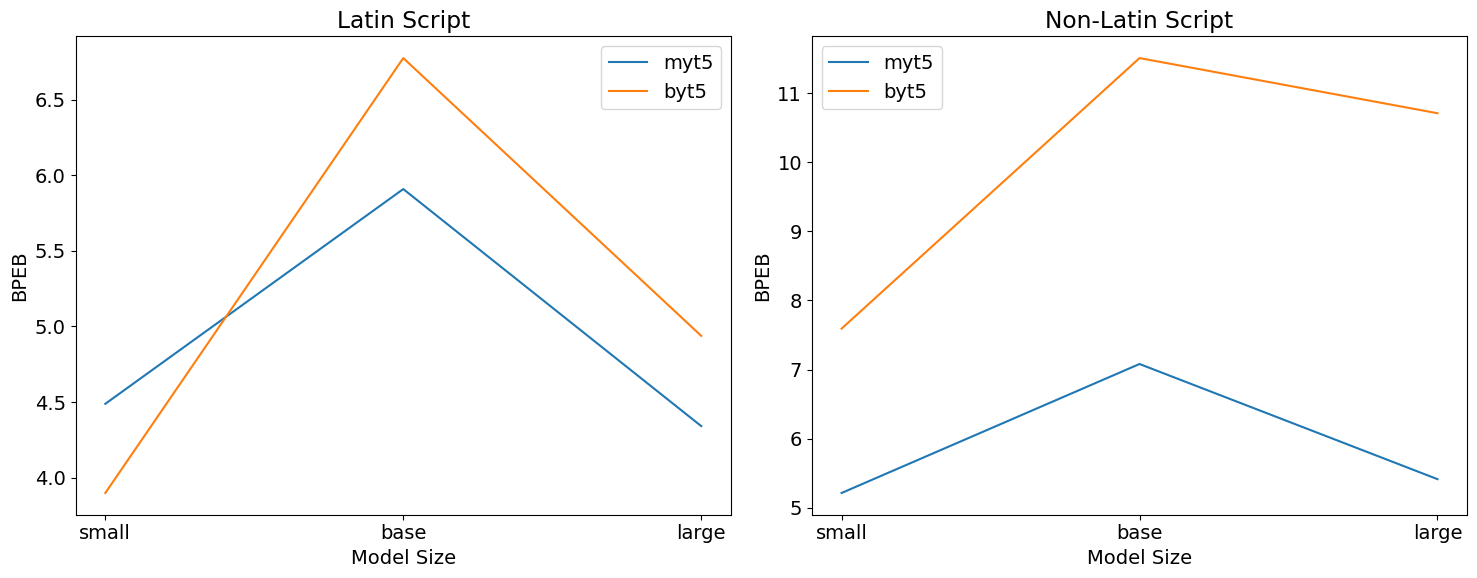

In [139]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for 'by' models
sctipt_latin_avg = script_avg[script_avg['Script'] == 'Latin']
axs[0].plot(sctipt_latin_avg[sctipt_latin_avg['Morphological']]['Size'],
            sctipt_latin_avg[sctipt_latin_avg['Morphological']]['NLL'], label='myt5')
axs[0].plot(sctipt_latin_avg[~sctipt_latin_avg['Morphological']]['Size'],
            sctipt_latin_avg[~sctipt_latin_avg['Morphological']]['NLL'], label='byt5')
axs[0].set_title('Latin Script')
axs[0].set_xlabel('Model Size')
axs[0].set_ylabel('BPEB')
axs[0].legend()

sctipt_nlatin_avg = script_avg[script_avg['Script'] != 'Latin']
axs[1].plot(sctipt_nlatin_avg[sctipt_nlatin_avg['Morphological']]['Size'],
            sctipt_nlatin_avg[sctipt_nlatin_avg['Morphological']]['NLL'], label='myt5')
axs[1].plot(sctipt_nlatin_avg[~sctipt_nlatin_avg['Morphological']]['Size'],
            sctipt_nlatin_avg[~sctipt_nlatin_avg['Morphological']]['NLL'], label='byt5')
axs[1].set_title('Non-Latin Script')
axs[1].set_xlabel('Model Size')
axs[1].set_ylabel('BPEB')
axs[1].legend()

plt.tight_layout()
plt.show()
fig.savefig('bpeb_size_comparision.png')